In [94]:
import os

os.environ["PYSYN_CDBS"] = "/home/ruizhew/POSEIDON/inputs/stellar_grids/"
os.environ["POSEIDON_input_data"] = "/home/ruizhew/POSEIDON/inputs/"
import matplotlib

params = {
    "legend.fontsize": 25,
    "axes.labelsize": 30,
    "axes.titlesize": 25,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
}
matplotlib.rcParams.update(params)

In [2]:
from __future__ import absolute_import, unicode_literals, print_function
from POSEIDON.high_res import (
    fast_filter,
    get_rot_kernel,
    fit_uncertainties,
)
import math, os
import numpy as np
import pickle
import pickle
from scipy import constants
from numba import jit
from astropy.io import fits
from scipy import interpolate
from POSEIDON.core import (
    create_star,
    create_planet,
    define_model,
    make_atmosphere,
    read_opacities,
    wl_grid_constant_R,
    wl_grid_line_by_line,
    compute_spectrum,
)
from POSEIDON.constants import R_Sun
from POSEIDON.visuals import plot_stellar_flux
from POSEIDON.constants import R_J, M_J
import numpy as np
from spectres import spectres
from tqdm import tqdm
from multiprocessing import Pool
import time

# ***** Define stellar properties *****#


R_s = 1.21 * R_Sun  # Stellar radius (m)
T_s = 5605.0  # Stellar effective temperature (K)
Met_s = -0.04  # Stellar metallicity [log10(Fe/H_star / Fe/H_solar)]
log_g_s = 4.56  # Stellar log surface gravity (log10(cm/s^2) by convention)
# ***** Define planet properties *****#

planet_name = "WASP-77Ab"  # Planet name used for plots, output files etc.

R_p = 1.21 * R_J  # Planetary radius (m)
M_p = 0.07 * M_J  # Mass of planet (kg)
g_p = 4.3712  # Gravitational field of planet (m/s^2)
T_eq = 1043.8  # Equilibrium temperature (K)

# Create the planet object
planet = create_planet(planet_name, R_p, mass=M_p, gravity=g_p, T_eq=T_eq)

# If distance not specified, use fiducial value
if planet["system_distance"] is None:
    planet["system_distance"] = 1  # This value only used for flux ratios, so it cancels
d = planet["system_distance"]

# %%
from POSEIDON.core import define_model, wl_grid_constant_R
from POSEIDON.utility import read_high_res_data

# ***** Define model *****#

model_name = "H2O, CO retrieval"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = ["H2O", "CO2", "CO", "CH4"]

method = "pca"
# high_res_params = ['a', 'b', 'dPhi', 'K_p', 'V_sys', 'W_conv']
high_res_params = ["a", "K_p", "V_sys"]

# Create the model object
# model = define_model(model_name, bulk_species, param_species,
#                     PT_profile = 'Madhu', high_res = high_res,
#                     high_res_params = high_res_params, R_p_ref_enabled=False)

model = define_model(
    model_name,
    bulk_species,
    param_species,
    PT_profile="Madhu",
    high_res_params=high_res_params,
)

# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))

# ***** Wavelength grid *****#

wl_min = 1.3  # Minimum wavelength (um)
wl_max = 2.6  # Maximum wavelength (um)
R = 250000  # Spectral resolution of grid

model["R"] = R
model["R_instrument"] = 66000  # Resolution of instrument

wl = wl_grid_constant_R(wl_min, wl_max, R)

# Create the stellar object
star = create_star(R_s, T_s, log_g_s, Met_s, wl=wl, stellar_grid="phoenix")

data_dir = "./data/WASP-77Ab/"

data = read_high_res_data(data_dir, method="pca", spectrum_type="emission")
data["V_sin_i"] = 4.5
model["W_conv"] = 401
opacity_treatment = "opacity_sampling"


# ***** Read opacity data *****#

opacity_treatment = "opacity_sampling"

# Define fine temperature grid (K)
T_fine_min = 2000  # 400 K lower limit suffices for a typical hot Jupiter
T_fine_max = 4000  # 2000 K upper limit suffices for a typical hot Jupiter
T_fine_step = 20  # 20 K steps are a good tradeoff between accuracy and RAM

T_fine = np.arange(T_fine_min, (T_fine_max + T_fine_step), T_fine_step)

# Define fine pressure grid (log10(P/bar))
log_P_fine_min = -5.0  # 1 ubar is the lowest pressure in the opacity database
log_P_fine_max = 2  # 100 bar is the highest pressure in the opacity database
log_P_fine_step = 0.2  # 0.2 dex steps are a good tradeoff between accuracy and RAM

log_P_fine = np.arange(
    log_P_fine_min, (log_P_fine_max + log_P_fine_step), log_P_fine_step
)

# Now we can pre-interpolate the sampled opacities (may take up to a minute)
opac = read_opacities(model, wl, opacity_treatment, T_fine, log_P_fine)

# ***** Specify fixed atmospheric settings for retrieval *****#
# Specify the pressure grid of the atmosphere
P_min = 1.0e-5  # 0.1 ubar
P_max = 100  # 100 bar
N_layers = 100  # 100 layers

# We'll space the layers uniformly in log-pressure
P = np.logspace(np.log10(P_max), np.log10(P_min), N_layers)

# Specify the reference pressure and radius
P_ref = 1e-5  # Reference pressure (bar)
R_p_ref = R_p  # Radius at reference pressure


params = (-6, -6, -6, -6, 0.3, 0.3, -1, -2, 1, 3000)
log_H2O, log_CO, log_CO2, log_CH4, a1, a2, log_P1, log_P2, log_P3, T_ref = params

PT_params = np.array([a1, a2, log_P1, log_P2, log_P3, T_ref])
log_X_params = np.array([[log_H2O, log_CO, log_CO2, log_CH4]])

atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
F_p_obs = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="direct_emission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref' 'log_H2O'
 'log_CO2' 'log_CO' 'log_CH4' 'a' 'K_p' 'V_sys']
Reading in cross sections in opacity sampling mode...
H2-H2 done
H2-He done
H2-CH4 done
CO2-H2 done
CO2-CO2 done
CO2-CH4 done
H2O done
CO2 done
CO done
CH4 done
Opacity pre-interpolation complete.


In [3]:
model_name = "Continuum"  # Model name used for plots, output files etc.

bulk_species = ["H2", "He"]  # H2 + He comprises the bulk atmosphere
param_species = []

# Create the model object
model = define_model(model_name, bulk_species, param_species, PT_profile="Madhu")
model["R_instrument"] = 66000
model["R"] = 250000
# Check the free parameters defining this model
print("Free parameters: " + str(model["param_names"]))
log_X_params = np.array([[]])
atmosphere = make_atmosphere(planet, model, P, P_ref, R_p_ref, PT_params, log_X_params)

# Generate planet surface flux
continuum = compute_spectrum(
    planet, star, model, atmosphere, opac, wl, spectrum_type="direct_emission"
)

Free parameters: ['R_p_ref' 'a1' 'a2' 'log_P1' 'log_P2' 'log_P3' 'T_ref']


In [4]:
from scipy.ndimage import gaussian_filter1d

star["F_star"] = gaussian_filter1d(star["F_star"], 3)
F_s = star["F_star"]
wl_s = star["wl_star"]

In [5]:
F_s_interp = spectres(wl, wl_s, F_s)
F_s_obs = (R_s / d) ** 2 * F_s_interp  # observed flux of star on earth
model["R_instrument"] = 66000
model["R"] = 250000
# instrument profile convolution
R_instrument = model["R_instrument"]
R = model["R"]
data["V_sin_i"] = 4.5
V_sin_i = data["V_sin_i"]
rot_kernel = get_rot_kernel(V_sin_i, wl, 401)
F_p_rot = np.convolve(
    F_p_obs, rot_kernel, mode="same"
)  # calibrate for planetary rotation
xker = np.arange(-20, 21)
sigma = (R / R_instrument) / (
    2 * np.sqrt(2.0 * np.log(2.0))
)  # model is right now at R=250K.  IGRINS is at R~45K. We make gaussian that is R_model/R_IGRINS ~ 5.5
yker = np.exp(
    -0.5 * (xker / sigma) ** 2.0
)  # instrumental broadening kernel; not understand
yker /= yker.sum()
F_p_conv = np.convolve(F_p_rot, yker, mode="same")
F_s_conv = np.convolve(
    F_s_obs, yker, mode="same"
)  # no need to times (R)^2 because F_p, F_s are already observed value on Earth

In [6]:
from POSEIDON.utility import read_high_res_data
from POSEIDON.high_res import fit_uncertainties
import numpy as np
import matplotlib.pyplot as plt
import pickle

data_path = "/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-77Ab/"
data = read_high_res_data(
    data_path,
    method="pca",
    spectrum_type="emission",
)
data_arr = data["data_arr"]
data_scale = data["data_scale"]
data_raw = data_arr + data_scale
wl_grid = data["wl_grid"]
V_bary = data["V_bary"]
phi = data["phi"]
Ndet, Nphi, Npix = data_arr.shape

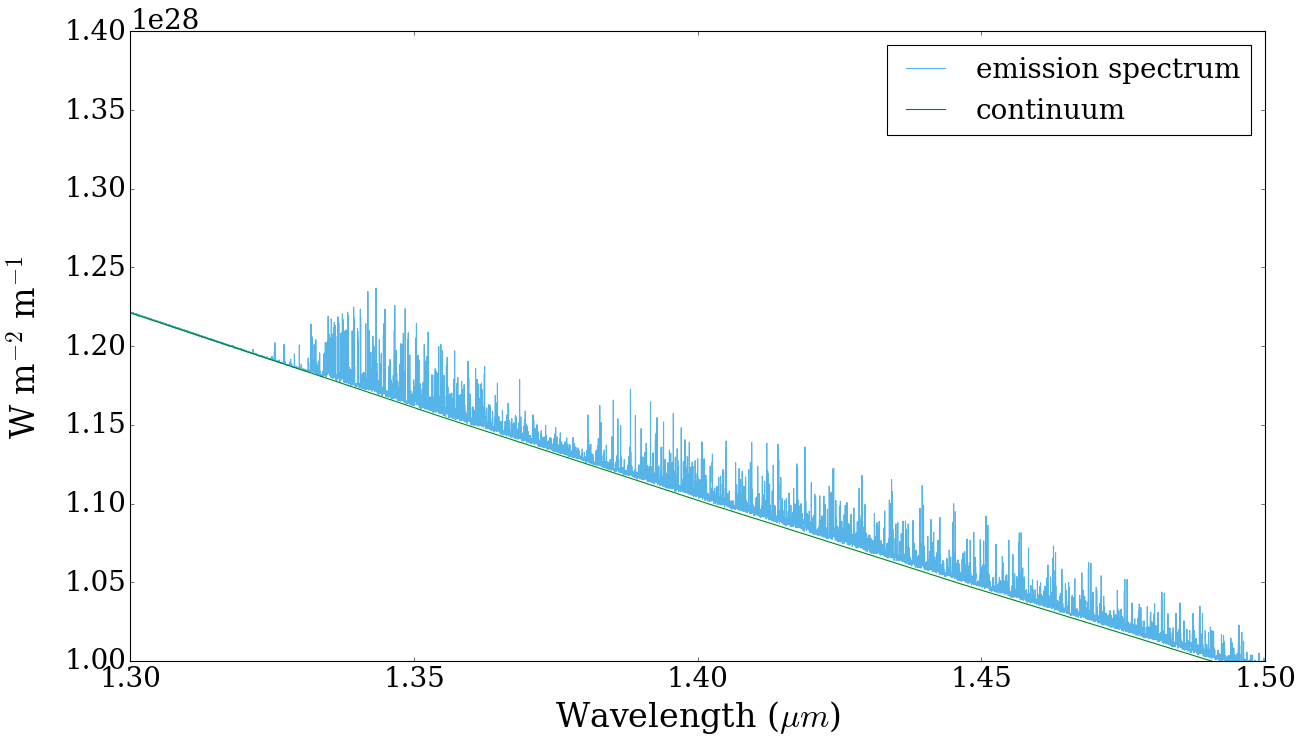

In [115]:
order_i = 15
wl_to_plot = wl_grid[order_i]
spectrum_to_plot = np.interp(wl_to_plot, wl, F_p_obs)
continuum_to_plot = np.interp(wl_to_plot, wl, continuum)
plt.figure(figsize=(17, 10))
plt.plot(wl, F_p_obs, label="emission spectrum", color="#56B4E9")
plt.plot(wl, continuum, label="continuum", color="#008716")
plt.xlim(1.3, 1.5)
plt.ylim(1e28, 1.4e28)
plt.xlabel(r"Wavelength ($\mu m$)")
plt.ylabel(
    "W m$^{-2}$ m$^{-1}$",
    rotation=90,
    verticalalignment="center",
    labelpad=35,
)
plt.legend()
plt.tight_layout()
plt.ticklabel_format(useOffset=False)

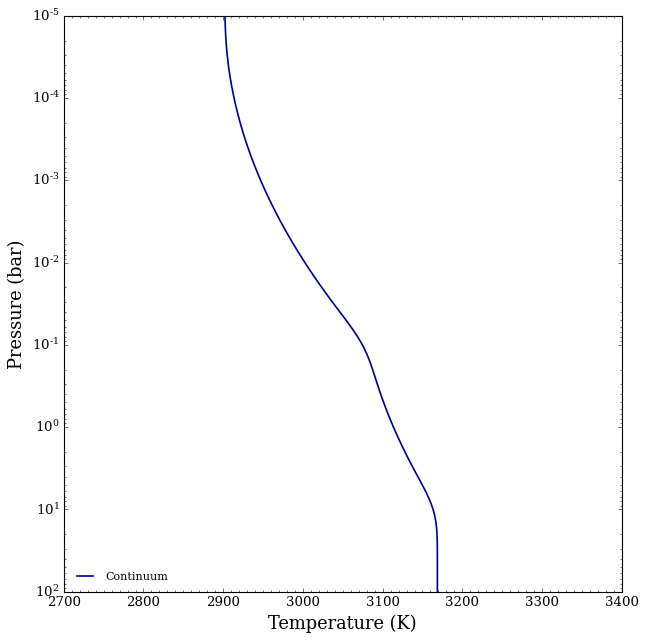

In [8]:
from POSEIDON.visuals import plot_PT

a = plot_PT(planet, model, atmosphere)

In [9]:
from POSEIDON.high_res import make_data_cube

data_path = "/home/ruizhew/POSEIDON/high_res_experiments/data/WASP-77Ab/"
data = read_high_res_data(
    data_path,
    method="pca",
    spectrum_type="emission",
)
data_arr = data["data_arr"]
data_scale = data["data_scale"]
data_raw = data_arr + data_scale
wl_grid = data["wl_grid"]
V_bary = data["V_bary"]
phi = data["phi"]
Ndet, Nphi, Npix = data_arr.shape

In [10]:
# from scipy.ndimage import gaussian_filter1d, median_filter

# N_order, N_phi, N_wl = data_arr.shape
# blaze = np.zeros((Ndet, Nphi, Npix))
# for j in range(N_order):
#     for i in range(N_phi):
#         blaze[j, i] = gaussian_filter1d(median_filter(data_scale[j, i], 50), 10)
# plt.plot(blaze[10, 10])
# plt.plot(data_raw[10, 10])
# plt.plot(data_scale[10, 10]/ blaze[10,10])

In [55]:
N_order, N_phi, N_wl = data_arr.shape
V_sys = 10
K_p = -200
# Time-resolved total radial velocity
RV_p = V_sys + V_bary + K_p * np.sin(2 * np.pi * phi)
# V_sys is an additive term around zero
dl_p = RV_p * 1e3 / constants.c  # delta lambda, for shifting

K_s = 0.3229
RV_s = (
    V_sys + V_bary - K_s * np.sin(2 * np.pi * phi)
) * 0  # Velocity of the star is very small compared to planet's velocity and it's already be corrected
dl_s = RV_s * 1e3 / constants.c  # delta lambda, for shifting
F_p_arr = np.zeros((N_order, N_phi, N_wl))
F_s_arr = np.zeros((N_order, N_phi, N_wl))
# Looping through each order and computing total log-L by summing logLs for each obvservation/order
F_p_F_s = np.zeros((N_order, N_phi, N_wl))
for j in range(N_order):  # Nord = 44 This takes 2.2 seconds to complete
    wl_slice = wl_grid[j].copy()  # Cropped wavelengths
    for i in range(N_phi):  # This for loop takes 0.025 seconds Nphi = 79
        wl_shifted_p = wl_slice * (1.0 - dl_p[i])
        F_p = np.interp(wl_shifted_p, wl, F_p_obs)
        wl_shifted_s = wl_slice * (1.0 - dl_s[i])
        F_s = np.interp(wl_shifted_s, wl, F_s_obs)
        F_s = F_s
        F_p_F_s[j, i, :] = F_p / F_s
        F_p_arr[j, i, :] = F_p
        F_s_arr[j, i, :] = F_s

data_injected = data_scale + F_p_F_s * data_scale

In [56]:
data_ideal = 1000 * F_p_arr + F_s_arr

In [57]:
data_scale_injected, data_arr_injected = make_data_cube(data_injected)

In [91]:
from sklearn.decomposition import TruncatedSVD

model_filtered = np.zeros((N_order, N_phi, N_wl))
for i in range(N_order):
    model_injected = (1 + F_p_F_s[i]) * data_scale[i, :, :]
    svd = TruncatedSVD(n_components=4, n_iter=4, random_state=42).fit(model_injected)
    model_filtered[i] = model_injected - (
        svd.transform(model_injected) @ svd.components_
    )

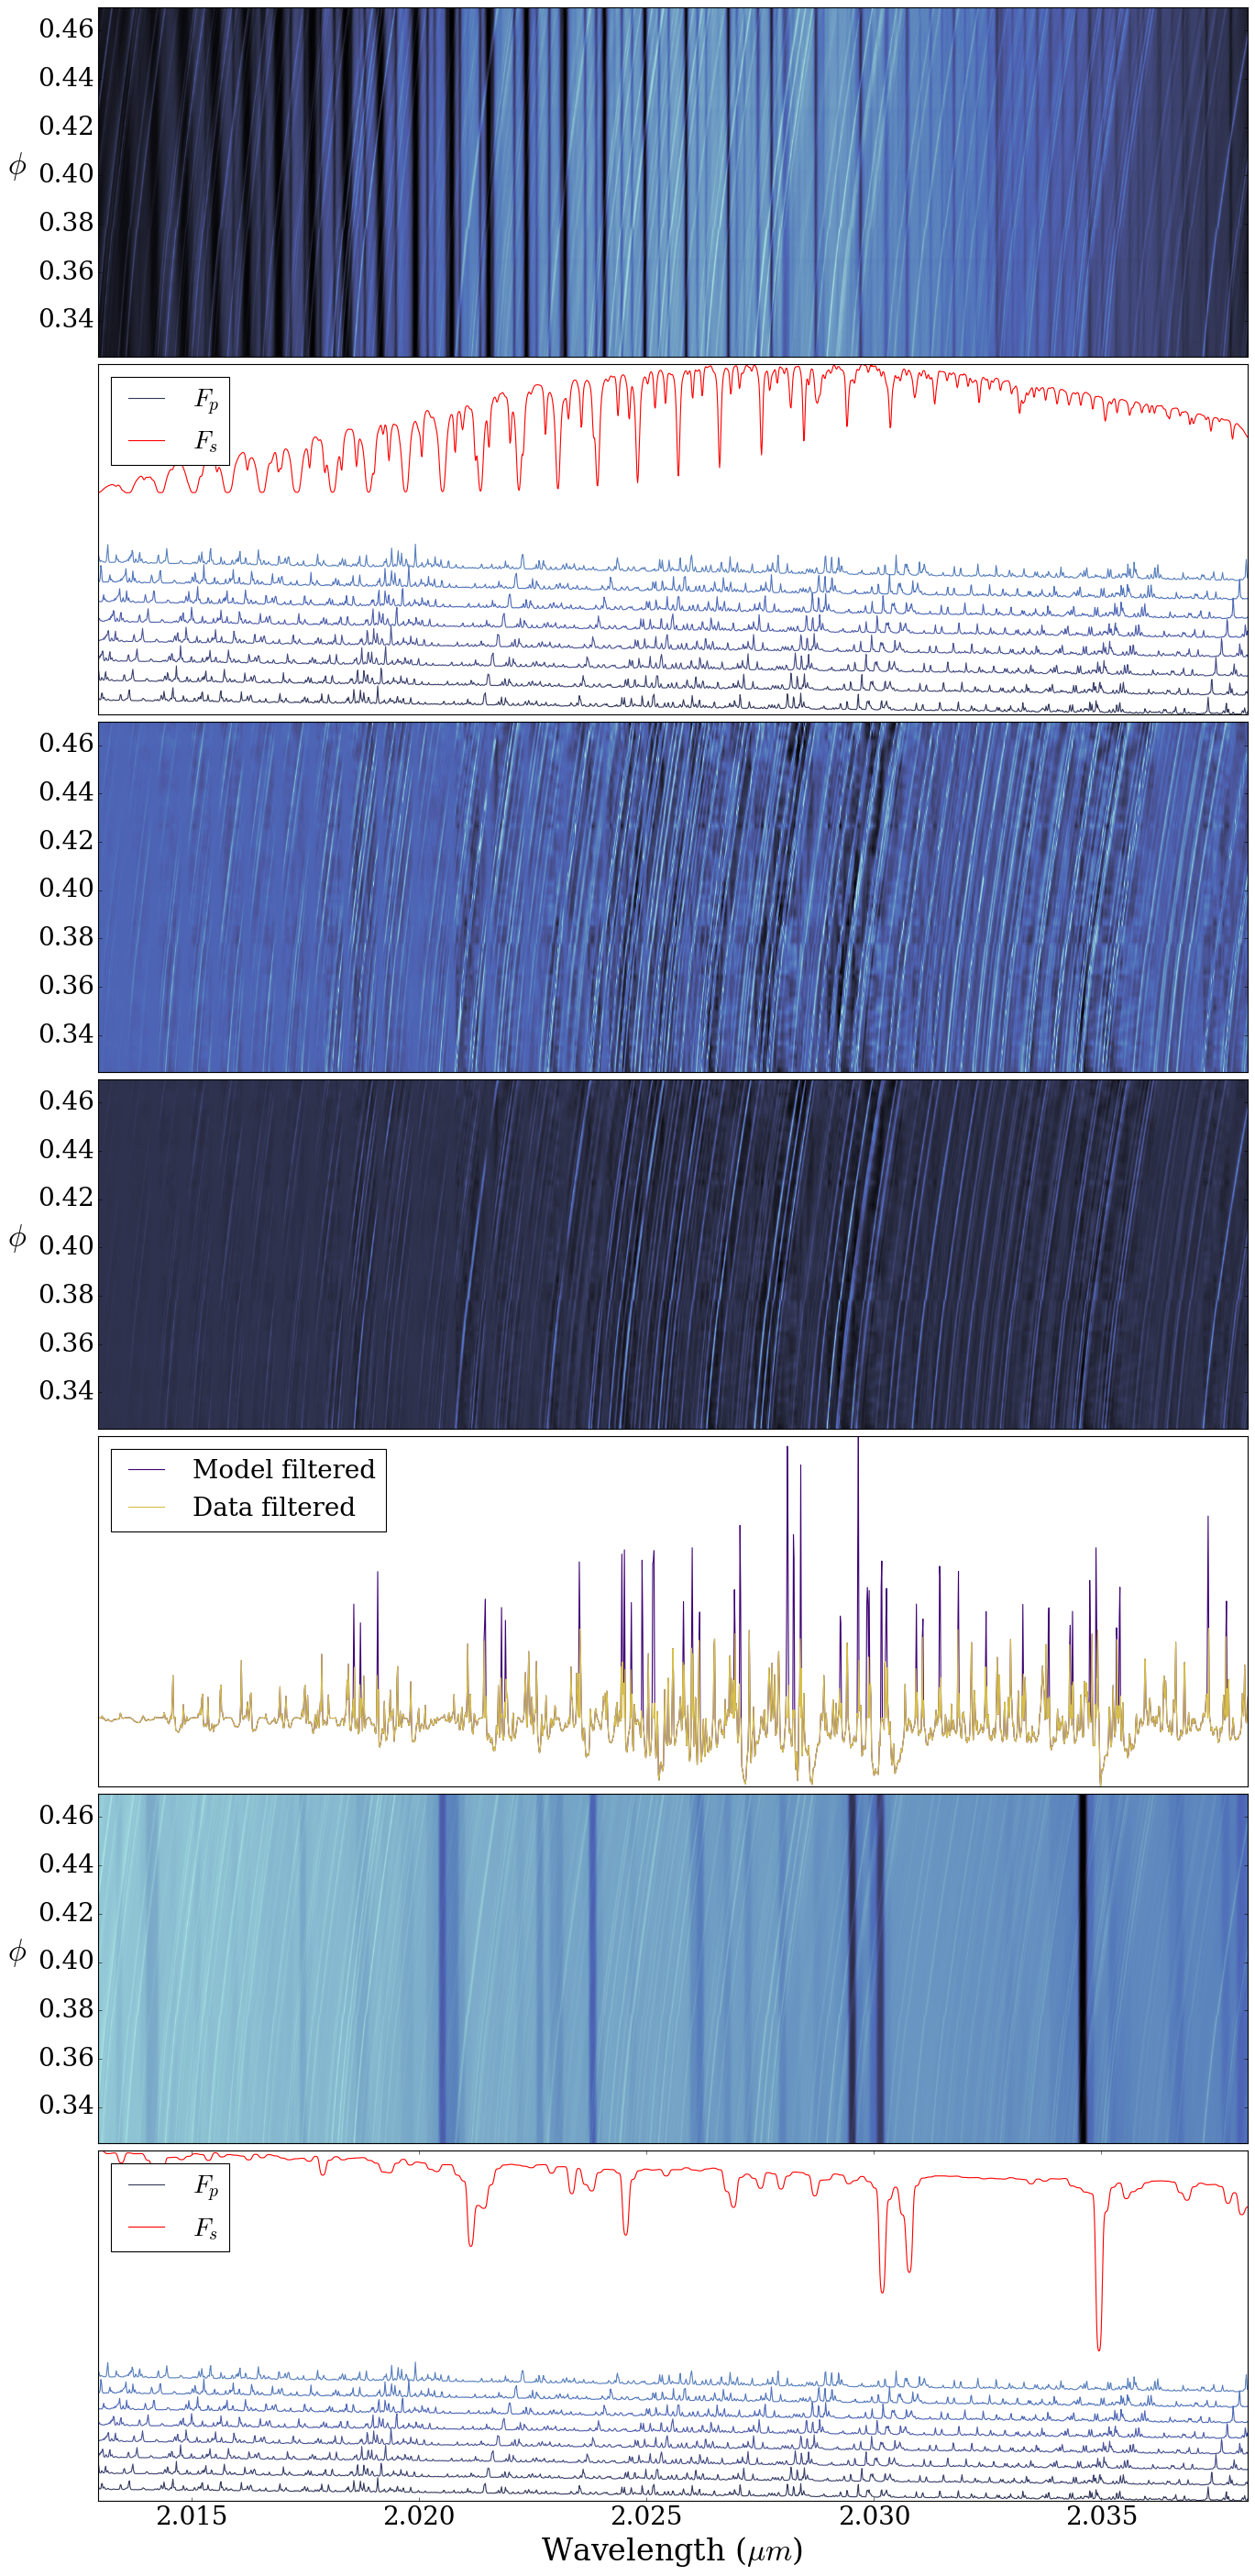

In [120]:
import colormaps as cmaps
import cmasher as cmr

phi = pickle.load(open(data_path + "/phi.pic", "rb"))
# output_path = "./CC_output/WASP-77b-injection/"
# os.makedirs(output_path, exist_ok=True)
colors = cmr.take_cmap_colors(
    "cmr.rainforest", 2, cmap_range=(0.2, 0.8), return_fmt="hex"
)
cmap = cmr.sapphire  # cmaps.lapaz

Fp_colors = cmr.take_cmap_colors(
    "cmr.sapphire", 10, cmap_range=(0.3, 0.7), return_fmt="hex"
)

model_color = colors[0]
data_color = colors[-1]
Fs_color = "red"

num_plots = 7
data_raw = data_arr + data_scale
fig, axes = plt.subplots(
    num_plots, 1, figsize=(17, num_plots * 5), constrained_layout=True
)
order_i = 15

wl_to_plot = wl_grid[order_i]

plot_i = 0

im0 = axes[plot_i].imshow(
    # order_to_plot * models_shifted[order_i] ** 3,
    data_injected[order_i]
    + 20
    * F_p_arr[order_i]
    / np.mean(F_p_arr[order_i])
    * np.mean(data_injected[order_i]),
    aspect="auto",
    origin="lower",
    cmap=cmap,
    # vmin=0,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)


axes[plot_i].set_ylabel(r"$\phi$", rotation=0, labelpad=20)
# fig.colorbar(
#     im0, ax=axes[0], orientation="vertical", pad=0.005, shrink=0.9
# ).formatter.set_useOffset(False)

for i in range(num_plots - 1):
    axes[i].xaxis.set_visible(False)

plot_i += 1
axes[plot_i].plot(wl_to_plot, F_p_arr[order_i][0], color=Fp_colors[0], label=r"$F_p$")
for i in np.arange(10, N_phi, 10):
    axes[plot_i].plot(
        wl_to_plot, F_p_arr[order_i][i] * (1 + i / 250), color=Fp_colors[i // 10]
    )


im1 = axes[plot_i].plot(
    wl_to_plot,
    ((data_injected[order_i][0] / np.mean(data_injected[order_i][0]) - 1) * 0.1 + 1)
    * np.mean(F_p_arr[order_i][0])
    * 1.6,
    label=r"$F_s$",
    color=Fs_color,
)

axes[plot_i].ticklabel_format(useOffset=False)
axes[plot_i].set_xlim(np.min(wl_to_plot), np.max(wl_to_plot))
axes[plot_i].legend(loc="upper left")
axes[plot_i].set_yticks([])

plot_i += 1
im2 = axes[plot_i].imshow(
    data_arr_injected[order_i],
    aspect="auto",
    origin="lower",
    cmap=cmap,
    # vmin=vmin,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)


# fig.colorbar(
#     im2, ax=axes[2], orientation="vertical", pad=0.005, shrink=0.9
# ).formatter.set_useOffset(False)

plot_i += 1
im3 = axes[plot_i].imshow(
    model_filtered[order_i],
    aspect="auto",
    origin="lower",
    cmap=cmap,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)
axes[plot_i].set_ylabel(r"$\phi$", rotation=0, labelpad=20)

plot_i += 1
im4 = axes[plot_i].plot(
    wl_to_plot,
    model_filtered[order_i][0],
    label="Model filtered",
    color=model_color,
)

axes[plot_i].plot(
    wl_to_plot,
    data_arr_injected[order_i][0],
    label="Data filtered",
    color=data_color,
)

axes[plot_i].ticklabel_format(useOffset=False)
axes[plot_i].set_xlim(np.min(wl_to_plot), np.max(wl_to_plot))
axes[plot_i].legend(loc="upper left")
axes[plot_i].set_yticks([])

plot_i += 1
im5 = axes[plot_i].imshow(
    data_ideal[order_i],
    aspect="auto",
    origin="lower",
    cmap=cmap,
    # vmin=vmin,
    # vmax=vmax,
    extent=[np.min(wl_to_plot), np.max(wl_to_plot), np.min(phi), np.max(phi)],
)
axes[plot_i].set_ylabel(r"$\phi$", rotation=0, labelpad=20)

plot_i += 1
axes[plot_i].plot(wl_to_plot, F_p_arr[order_i][0], color=Fp_colors[0], label=r"$F_p$")
for i in np.arange(10, N_phi, 10):
    axes[plot_i].plot(
        wl_to_plot, F_p_arr[order_i][i] * (1 + i / 250), color=Fp_colors[i // 10]
    )

im6 = axes[plot_i].plot(
    wl_to_plot,
    F_s_arr[order_i][0]
    * (np.mean(F_p_arr[order_i][0]) / np.mean(F_s_arr[order_i][0]) * 1.8),
    label=r"$F_s$",
    color=Fs_color,
)
axes[plot_i].ticklabel_format(useOffset=False)
axes[plot_i].set_xlim(np.min(wl_to_plot), np.max(wl_to_plot))
axes[plot_i].legend(loc="upper left")
axes[plot_i].set_yticks([])
axes[plot_i].set_xlabel(r"Wavelength ($\mu m$) ")

# plt.tight_layout()
# fig.subplots_adjust(hspace=0.02)


plt.ticklabel_format(useOffset=False)

In [ ]:
output_path = "./data/WASP-77Ab-injection-6/"
os.makedirs(output_path, exist_ok=True)
pickle.dump(
    [wl_grid, data_scale_injected], open(output_path + "/data_scale.pic", "wb")
)  # this is all the telluric crud you removed. Will be used for model injection
pickle.dump(
    [wl_grid, data_arr_injected], open(output_path + "/data_arr.pic", "wb")
)  # this is the "PCA'd" cube. It just looks like noise. The planet is in there somewhere...

: 